**Instead of using statistical models like bigrams or trigrams, we will use a Multi-Layer Perceptron (MLP). This is because the array matrix required for storing letter combinations grows exponentially as 26^x, where x is the number of letter combinations. Since 26 represents the number of letters in the alphabet, this approach would require excessive computation and memory. Using a neural network like an MLP is a more efficient alternative.**

<div align = 'center'>
    <img src="./MLP_Arch.png" width="500">
<div>


---

# Step 1 Batch/Input Layer

In [5]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#Read in txt file
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [8]:
# Convert the alphabet to a index integer using mapping 
chars = sorted(list(set(''.join(words))))
# print(chars)
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


For this following FUnction we are creating a dataset based off of indexs based on the previous mapping and storing them as tensors for each word. For example there is 5 words, so we will end up with a dataset of 5 empty arrays [. . .] and then a variation of all the words as shown in the print out of the funciton: 

In [9]:
# This is the block size for how big the input is going to be for the MLP
block_size = 3

X,y = [],[] # X is the input, y is the Label
count = 5
for w in words[:5]: 
    print(w)
    context = [0] * block_size
    count += len(w)
    for ch in w + '.': 
        ix = stoi[ch]
        # print('ch:', ch)
        # print('ix', ix)
        X.append(context)
        # print('context', context)
        y.append(ix)
        print(''.join([itos[i] for i in context]),'----->', itos[ix])
        context = context[1:] + [ix] 
        
print(count)
X = torch.tensor(X)
Y = torch.tensor(y)

emma
... -----> e
..e -----> m
.em -----> m
emm -----> a
mma -----> .
olivia
... -----> o
..o -----> l
.ol -----> i
oli -----> v
liv -----> i
ivi -----> a
via -----> .
ava
... -----> a
..a -----> v
.av -----> a
ava -----> .
isabella
... -----> i
..i -----> s
.is -----> a
isa -----> b
sab -----> e
abe -----> l
bel -----> l
ell -----> a
lla -----> .
sophia
... -----> s
..s -----> o
.so -----> p
sop -----> h
oph -----> i
phi -----> a
hia -----> .
32


### Function Summary:

This function converts words into training data by mapping characters to indices and storing them as tensors.  

- **Block Size (`3`)**: Defines how many previous characters form the input.  
- **`X` (Input) & `y` (Labels)**:  
  - `X` stores context windows of size 3.  
  - `y` stores the next character for each window.  
- **Process**:  
  1. Start with an empty context (`[0, 0, 0]`).  
  2. Slide through each word (plus `.` at the end).  
  3. Store the context in `X` and the next character in `y`.  
  4. Shift the context and repeat.  
- **Example (`"emma"`)**:  
  ```
  ...  → e  
  ..e  → m  
  .em  → m  
  emm  → a  
  mma  → .  
  ```  
- Finally, `X` and `y` are converted to PyTorch tensors.

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [11]:
X[:5], Y[:5] # Printing the first 5 rows of the (X) (Y) tensor

# X defines the sequence of characters, and Y defines the next character prediction in the sequence

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1]]),
 tensor([ 5, 13, 13,  1,  0]))

As discussed before the dataset (X) resulted in 32 total rows, 5 empty intialization rows, and 27 variation rows that determine the next pattern. The block size determines how many characters will be remebered in the sequence. 

In [12]:
# C is the randome embedding matrix, with 27 rows and 2 columns
C = torch.randn((27,2))

# Embedding the input tensor X using the embedding matrix C
embedding = C[X]
embedding.shape

torch.Size([32, 3, 2])

**Embedding Summary**  

- **Embeddings map characters to vectors** in a continuous space instead of treating them as separate symbols.  
- **Initially random**, embeddings get optimized during training to capture character relationships.  
- **Example:** A sequence `[0,0,5]` (where `5 = e`) retrieves vectors from an embedding matrix.  
- **Training adjusts these vectors** so similar characters end up closer in space.  
- **Benefit:** Helps the model understand patterns and improves predictions without manual rules.

<div align = 'center'>
    <img src="./2d_Vector_Embedding.png" width="500">
<div>


---

# Step 2: Hidden Layers

In [13]:
W1 = torch.randn((6,100)) # This is the weights that will be input to the first layer
b1 = torch.randn((100)) # This is the bias that will be input to the first layer

We flatten the embeddings from `torch.Size([32, 3, 2]) → torch.Size([32, 6])` to make them compatible for weight multiplication. This is done using `torch.cat`, which concatenates the matrix into a single vector per sample.

Method 1

In [14]:
torch.cat([embedding[:, 0, :], embedding[:, 1, :], embedding[:, 2, :]], 1).shape # Inefficent way of doing it due to new memory being created

torch.Size([32, 6])

If the block size changes (e.g., from 3 to 5), the current approach would need manual updates. To avoid hardcoding, we use `torch.unbind`, which dynamically unravels the tensor, making the code more flexible.

In [15]:
# Use of torch.unbind to 
# torch.unbind(embedding, 1)
# This is equivalent to [embedding[:, 0, :], embedding[:, 1, :], embedding[:, 2, :]

torch.cat(torch.unbind(embedding, 1), 1).shape
# We get the same result as above and it is dynamic for block size

torch.Size([32, 6])

Mehtod 2 More efficent

We use `torch.view()` to reshape the tensor into any desired dimensions. For example, it allows us to convert a tensor from `torch.Size([32, 3, 2])` to `torch.Size([32, 6])` dynamically, making it adaptable to different input shapes.

In [16]:
embedding.view(32,6) # This allows us to make the embedding matrix in a different shape
embedding.view(32,6).shape
# Testing similarity 
# embedding.view(32,6) == torch.cat(torch.unbind(embedding, 1), 1)

torch.Size([32, 6])

In [17]:
# So to multiply the weights with inputs 
h = embedding.view(32,6) @ W1 + b1
h

tensor([[-0.4256,  0.4017,  3.7514,  ..., -1.8903,  0.7083,  0.0815],
        [ 0.2989, -0.3466,  2.7397,  ..., -1.5563,  1.0359,  0.3680],
        [ 0.6238,  0.7273,  4.3425,  ..., -2.3373,  0.7108,  0.2357],
        ...,
        [-1.2488,  1.6563,  5.3285,  ..., -2.2634,  3.0306,  1.7738],
        [ 0.5659,  1.5330, -0.1985,  ...,  0.6898, -3.7425,  1.7541],
        [ 1.1403,  0.3971,  3.4217,  ..., -2.9865, -2.6413, -0.6490]])

- **Multiplies** the **32 input vectors (each of size 6)** with **100 random intialized weights** from `W1 (6, 100)`.  
- **Adds bias `b1`** for each of the 32 inputs, resulting in a final shape of `torch.Size([32, 100])`.  

This transforms the input into a **100-dimensional hidden representation** for each sample.

Instead of hardcoding 32 as the batch size in view(32,6), we can use -1 to make the code adaptable to any batch size. (-1) tells PyTorch to automatically infer the correct batch size based on the input. Input Size = The number of features per sample, Batch Size = The number of samples processed at once in a single forward pass.

In [18]:
# Using -1 for dynamic block size
h = embedding.view(-1,6) @ W1 + b1
h

tensor([[-0.4256,  0.4017,  3.7514,  ..., -1.8903,  0.7083,  0.0815],
        [ 0.2989, -0.3466,  2.7397,  ..., -1.5563,  1.0359,  0.3680],
        [ 0.6238,  0.7273,  4.3425,  ..., -2.3373,  0.7108,  0.2357],
        ...,
        [-1.2488,  1.6563,  5.3285,  ..., -2.2634,  3.0306,  1.7738],
        [ 0.5659,  1.5330, -0.1985,  ...,  0.6898, -3.7425,  1.7541],
        [ 1.1403,  0.3971,  3.4217,  ..., -2.9865, -2.6413, -0.6490]])

---

# Step 3: Softmax Layer

In [19]:
W2 = torch.randn((100,27)) 
b2 = torch.randn((27))

In [20]:
logits = h @ W2 + b2 # Hidden layers are multiplied by weights of softmax layer and bias are added 
logits.shape

torch.Size([32, 27])

In [21]:
counts = logits.exp() # Taking the exponential of the logits 

In [22]:
# Normalizing the counts to get the probability of each character
prob = counts / counts.sum(1, keepdim=True)
print(prob.shape) # should return 32, 27, for 32 sameples and 27 characters

print(prob[0].sum()) # The sume of the probabilities should be 1

torch.Size([32, 27])
tensor(1.0000)


In [23]:
prob[torch.arange(32), Y] # This is the probability of the correct character

tensor([6.0827e-09, 2.4871e-12, 7.7228e-18, 1.5604e-04, 3.8243e-18, 1.3298e-05,
        1.0872e-01, 1.1855e-19, 1.4757e-26, 4.1704e-15, 1.9371e-24, 1.5987e-16,
        4.2375e-12, 7.4562e-12, 4.2404e-21, 2.7922e-17, 1.7152e-12, 3.1266e-22,
        4.6866e-13, 2.8840e-14, 8.2392e-18, 2.3712e-13, 3.4654e-32, 1.2694e-06,
        2.0686e-23, 5.4161e-08, 4.3403e-07, 6.8319e-16, 3.0911e-03, 3.6848e-15,
        2.5885e-16, 5.3698e-17])

In [24]:
loss = - prob[torch.arange(32), Y].log().mean() # This is the loss function
loss

tensor(32.2761)

---

# Cleaned Up Full MLP

In [25]:
X.shape, Y.shape # data set 

(torch.Size([32, 3]), torch.Size([32]))

In [26]:
# Step 1
g = torch.Generator().manual_seed(242424) # Seed for reproducibility
C = torch.rand((27,2), generator=g) # Random embedding matrix

#Step 2
W1 = torch.rand((6,100), generator=g) # Random weights for the first layer
b1 = torch.rand((100), generator=g) # Random bias for the first layer

#Step 3
W2 = torch.rand((100,27), generator=g) # Random weights for the Softmax layer
b2 = torch.rand((27), generator=g) # Random bias for the Softmax layer
params = [C, W1, b1, W2, b2] # Parameters for the model

In [228]:
print('Total Number of Parameters: ', sum(p.nelement() for p in params)) # Total number of parameters in the model

Total Number of Parameters:  3481


In [229]:
embedding = C[X] # Embedding the input tensor X using the embedding matrix C
h = torch.tanh(embedding.view(-1,6) @ W1 + b1) # Hidden layer
logits = h @ W2 + b2 # Logits
counts = logits.exp() # Exponential of the logits
prob = counts / counts.sum(1, keepdim=True) # Normalizing the counts
loss = - prob[torch.arange(32), Y].log().mean() # Loss function
loss 

tensor(6.4533)

Instead of manually implementing the **cross-entropy loss function**, we use PyTorch’s built-in `torch.nn.functional.cross_entropy()`, which is more **optimized and efficient**.  

Unlike a manual implementation, this **does not create extra tensors** for computation. Instead, it clusters operations together, making it **faster** and more **memory-efficient**.  

In [230]:
for p in params: 
    p.requires_grad_() # Setting the requires_grad to True for all the parameters

In [231]:

# Training the model for 100 epochs
for _ in range(1000): 
    # Forward pass
    embedding = C[X] # Embedding the input tensor X using the embedding matrix C
    h = torch.tanh(embedding.view(-1,6) @ W1 + b1) # Hidden layer
    logits = h @ W2 + b2 # Logits
    loss = F.cross_entropy(logits, Y) # Cross entropy loss function
    
    # Backward pass (Gradient descent)
    for p in params: 
        p.grad = None
    loss.backward()

    #update the parameters
    for p in params: 
        p.data += -0.1 * p.grad
    
print(loss.item())

0.26707345247268677


Even with just **5 words**, the loss dropped from **6.6207 → 0.2613**, but **not to 0**.  

This happens because the **first character of each word is unpredictable**—the model starts with an **empty context**, meaning **any letter has an equal probability of being the first prediction**.  

---

# Now Training on the full dataset

In [232]:
# This is the block size for how big the input is going to be for the MLP
block_size = 3

X,y = [],[] # X is the input, y is the Label

for w in words: 
    context = [0] * block_size
    for ch in w + '.': 
        ix = stoi[ch]
        X.append(context)
        y.append(ix)
        context = context[1:] + [ix] 
        
X = torch.tensor(X)
Y = torch.tensor(y)

In [233]:
X.shape, X.dtype, Y.shape, Y.dtype
# Now we have 228146 samples and 3 characters in each sample

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [234]:
# Step 1
C = torch.rand((27,2), generator=g) # Random embedding matrix

#Step 2
W1 = torch.rand((6,100), generator=g) # Random weights for the first layer
b1 = torch.rand((100), generator=g) # Random bias for the first layer

#Step 3
W2 = torch.rand((100,27), generator=g) # Random weights for the Softmax layer
b2 = torch.rand((27), generator=g) # Random bias for the Softmax layer
params = [C, W1, b1, W2, b2] # Parameters for the model

In [235]:
for p in params: 
    p.requires_grad_() # Setting the requires_grad to True for all the parameters

In [236]:
# (Full-Batch Training)

# Training the model for 100 epochs
for _ in range(100): 
    # Forward pass
    embedding = C[X] # Embedding the input tensor X using the embedding matrix C
    h = torch.tanh(embedding.view(-1,6) @ W1 + b1) # Hidden layer
    logits = h @ W2 + b2 # Logits
    loss = F.cross_entropy(logits, Y) # Cross entropy loss function
    print(loss.item())
    # Backward pass (Gradient descent)
    for p in params: 
        p.grad = None
    loss.backward()

    #update the parameters
    for p in params: 
        p.data += -0.1 * p.grad
    


5.458654880523682
4.134350776672363
3.6846084594726562
3.4315357208251953
3.2931735515594482
3.209890604019165
3.1543283462524414
3.1108791828155518
3.073997735977173
3.041818380355835
3.013424873352051
2.9882843494415283
2.9660980701446533
2.9466917514801025
2.929917573928833
2.915576696395874
2.9033970832824707
2.89304518699646
2.8841745853424072
2.8764727115631104
2.869689702987671
2.8636467456817627
2.8582253456115723
2.853353977203369
2.8489959239959717
2.845128297805786
2.841737747192383
2.838808298110962
2.836317539215088
2.834233522415161
2.8325154781341553
2.831115245819092
2.8299827575683594
2.8290679454803467
2.828324317932129
2.8277108669281006
2.827195644378662
2.8267529010772705
2.8263626098632812
2.826009750366211
2.825683832168579
2.825377941131592
2.825086832046509
2.824805498123169
2.824531316757202
2.824262857437134
2.823997735977173
2.8237361907958984
2.8234760761260986
2.8232169151306152
2.8229572772979736
2.8226988315582275
2.8224384784698486
2.8221776485443115
2.

### This process is taking too long because it performs a backward pass on every individual sample. A more efficient and commonly used strategy is to accumulate batches of samples and only run the backward pass on these mini-batches, rather than doing it for each sample or only once every epoch.

---

# Full Training with Mini-Batch optimization

In [237]:
torch.randint(0, 5, (32,))

tensor([0, 4, 2, 3, 2, 1, 3, 3, 3, 3, 2, 3, 4, 1, 3, 2, 4, 3, 0, 2, 1, 3, 3, 0,
        3, 2, 1, 2, 0, 4, 3, 0])

**This function generates an array of 32 digits randomly that are between 0-5. We can use this funtionality on to produce minibatches from our dataset.**

In [238]:
# (Mini-Batch Training)

# Training the model for 100 epochs
for _ in range(100): 
    
    #Mini batch Construction
    ix = torch.randint(0, X.shape[0], (32,)) # Randomly selecting 32 indexes from dataset storing it in ix
    
    # Forward pass
    embedding = C[X[ix]] # using the randomly selected indexes to get the embedding matrix
    h = torch.tanh(embedding.view(-1,6) @ W1 + b1) # Hidden layer
    logits = h @ W2 + b2 # Logits
    loss = F.cross_entropy(logits, Y[ix]) # Cross entropy loss function
    print(loss.item())
    # Backward pass (Gradient descent)
    for p in params: 
        p.grad = None
    loss.backward()

    #update the parameters
    for p in params: 
        p.data += -0.1 * p.grad
    


2.963801622390747
2.6956963539123535
3.239279270172119
3.018012762069702
2.617950916290283
2.8693337440490723
2.8902199268341064
3.0995190143585205
2.9352731704711914
2.887397050857544
2.6415553092956543
3.128690242767334
2.7968180179595947
2.6242740154266357
2.8170371055603027
2.6576547622680664
2.9491546154022217
2.6247973442077637
3.020049571990967
2.739379405975342
3.1457886695861816
2.985626220703125
2.6417407989501953
3.1213576793670654
2.7520828247070312
2.778930902481079
3.018310308456421
2.518045425415039
2.5089945793151855
2.90983510017395
2.7599937915802
2.6922171115875244
3.0181729793548584
2.868490219116211
2.845430850982666
2.9273228645324707
3.0930087566375732
2.7054033279418945
2.7526283264160156
3.1314737796783447
2.7888083457946777
2.892881155014038
2.7210750579833984
2.9549689292907715
2.9408986568450928
2.688037872314453
3.016476631164551
2.772251605987549
2.5472254753112793
2.7773122787475586
2.934617042541504
2.7349462509155273
2.815654993057251
2.6488561630249023

We can see that now using mini-batches the speed dropped from 45 sec. to instant after the mini-batch ruling was applied this drastically reduced computation. 

- (Mini-Batch Training) significantly reduces computational cost per iteration by only computing gradients on a small subset of the data.
- (Full-Batch Training) requires computing gradients over the entire dataset, making it slower and potentially impractical for large datasets.


<div align = 'center'>
    <img src="./Mini-batch_gradient_descent.webp" width="500">
<div>


---

# Learning Rate Optimization
### Now we will look at the learning rate and how we can find the most optimal solution, common practice cross-validation

**Reset Variables**

In [239]:
# This is the block size for how big the input is going to be for the MLP
block_size = 3

X,y = [],[] # X is the input, y is the Label

for w in words: 
    context = [0] * block_size
    for ch in w + '.': 
        ix = stoi[ch]
        X.append(context)
        y.append(ix)
        context = context[1:] + [ix] 
        
X = torch.tensor(X)
Y = torch.tensor(y)

# Step 1
g = torch.Generator().manual_seed(3) # Seed for reproducibility
C = torch.rand((27,2), generator=g) # Random embedding matrix

#Step 2
W1 = torch.rand((6,100), generator=g) # Random weights for the first layer
b1 = torch.rand((100), generator=g) # Random bias for the first layer

#Step 3
W2 = torch.rand((100,27), generator=g) # Random weights for the Softmax layer
b2 = torch.rand((27), generator=g) # Random bias for the Softmax layer
params = [C, W1, b1, W2, b2] # Parameters for the model

for p in params: 
    p.requires_grad_() # Setting the requires_grad to True for all the parameters

---

In [240]:
# We determine the learing rate from the range 0f 10^-3 to 10^1
lre = torch.linspace(-3, 0,10000)
lrs = 10**lre

In [241]:
# (Mini-Batch Training)

lri = [] # Stored list for the learning rate
lossi = [] # Loss list of the model for the selected learning rate

for i in range(10000): 
    
    #Mini batch Construction
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    embedding = C[X[ix]] 
    h = torch.tanh(embedding.view(-1,6) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) 

    for p in params: 
        p.grad = None
    loss.backward()

    lr = lrs[i]
    for p in params: 
        p.data += -lr * p.grad # The -0.1 here is the learning rate
    
    lri.append(lre[i])
    lossi.append(loss.item())

loss.item()


2.4611849784851074

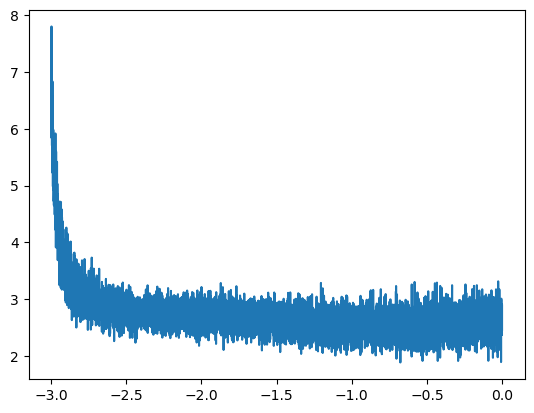

In [242]:
plt.plot(lri, lossi)
plt.show()

### In this we can see that the most optimal learning rate is for most optimal results. 

---

# Splitting Data - Prevent Overfitting
### Best way to prevent overfitting of a LLM is to split the dataset into 3 for training split, dev/validation split, and test split: 80%, 10%, 10%

### Reset Variables

In [243]:
# This is same code as before but now optimized to call for each split dataset
def build_dataset(words): 
    block_size = 3

    X,y = [],[]

    for w in words: 
        context = [0] * block_size
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix] 
            
    X = torch.tensor(X)
    Y = torch.tensor(y)
    
    return X,Y


# Setting Model Parameters
C = torch.rand((27,2), generator=g) # Random embedding matrix

#Step 2
W1 = torch.rand((6,100), generator=g) # Random weights for the first layer
b1 = torch.rand((100), generator=g) # Random bias for the first layer

#Step 3
W2 = torch.rand((100,27), generator=g) # Random weights for the Softmax layer
b2 = torch.rand((27), generator=g) # Random bias for the Softmax layer
params = [C, W1, b1, W2, b2] # Parameters for the model

for p in params: 
    p.requires_grad_() # Setting the requires_grad to True for all the parameters

### Split the Dataset

In [31]:
import random

random.seed(1222)
random.shuffle(words)

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

print(f"Total words: {len(words)}")
print(f"Training set range: (0 - {n1})")
print(f"Validation set range: ({n1} - {n2})")
print(f"Testing set range: ({n2} - {len(words)})")


Xtrain, Ytrain = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


Total words: 32033
Training set range: (0 - 25626)
Validation set range: (25626 - 28829)
Testing set range: (28829 - 32033)


In [245]:
Xtrain.shape, Ytrain.shape, Xval.shape, Yval.shape, Xtest.shape, Ytest.shape

(torch.Size([182382, 3]),
 torch.Size([182382]),
 torch.Size([22862, 3]),
 torch.Size([22862]),
 torch.Size([22902, 3]),
 torch.Size([22902]))

In [246]:
# Setting the dataset/labels for the training set
Dataset = Xtrain
Labels = Ytrain


for i in range(30000): 
    
    #Mini batch Construction
    ix = torch.randint(0, Dataset.shape[0], (32,))
    
    # Forward pass
    embedding = C[Dataset[ix]] 
    h = torch.tanh(embedding.view(-1,6) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Labels[ix]) 

    for p in params: 
        p.grad = None
    loss.backward()

    lr = .1 # Learning rate
    for p in params: 
        p.data += -lr * p.grad 

loss.item()


2.06899356842041

### Testing the Validation set
**Testing the model on validation set to see if model is overfitting**

In [247]:
dataset = Xval
labels = Yval   
   
embedding = C[dataset] 
h = torch.tanh(embedding.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, labels) 
loss

tensor(2.3657, grad_fn=<NllLossBackward0>)

In [248]:
dataset = Xtest
labels = Ytest   
   
embedding = C[dataset] 
h = torch.tanh(embedding.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, labels) 
loss

tensor(2.3396, grad_fn=<NllLossBackward0>)

### Here we can see that the loss of the Validation and Testing set, are roughly equal. This can indicate that the model is under fitting. 

### We will need to optimize the network in order to perfrom better, we can do this by increasing the networks parameters to better fit the dataset. 

---

# Increasing the Size of the N.N. 
**We can increase the Parameters of the Neural Network, inorder for it to better fit the data**

### Increasing the Neurons in the Hidden Layer (Step 2)

In [249]:
# Funtion for the datasets

def build_dataset(words): 
    block_size = 3

    X,y = [],[]

    for w in words: 
        context = [0] * block_size
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix] 
            
    X = torch.tensor(X)
    Y = torch.tensor(y)
    
    return X,Y


In [250]:
# Setting Model Parameters
g = torch.Generator().manual_seed(5) 
C = torch.rand((27,2), generator=g)

#Step 2
W1 = torch.rand((6,300), generator=g) # Changed hidden layer neurons from 100 to 300
b1 = torch.rand((300), generator=g)  # Changed bias from 100 to 300

#Step 3
W2 = torch.rand((300,27), generator=g) # Changed softmax layer input from 100 to 300
b2 = torch.rand((27), generator=g)
params = [C, W1, b1, W2, b2] 

for p in params: 
    p.requires_grad_() 
    
print('New # of Parameters:', sum(p.nelement() for p in params))

New # of Parameters: 10281


In [251]:
# (Mini-Batch Training)
dataset = Xtrain
labels = Ytrain

lossi = [] # Loss list of the model for the selected learning rate
steps = [] 

for i in range(30000): 
    
    #Mini batch Construction
    ix = torch.randint(0, dataset.shape[0], (32,))
    
    # Forward pass
    embedding = C[dataset[ix]] 
    h = torch.tanh(embedding.view(-1,6) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, labels[ix]) 

    for p in params: 
        p.grad = None
    loss.backward()

    lr = .01
    for p in params: 
        p.data += -lr * p.grad 
    
    lossi.append(loss.item())
    steps.append(i)

loss.item()


2.4386327266693115

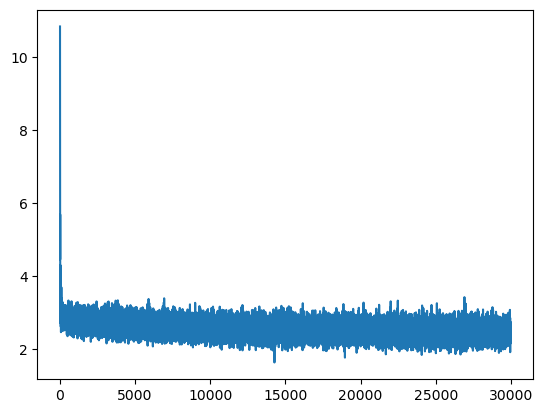

In [252]:
plt.plot(steps, lossi)
plt.show()

In [253]:
dataset = Xtrain
labels = Ytrain   
   
embedding = C[dataset] 
h = torch.tanh(embedding.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, labels) 
loss

tensor(2.4564, grad_fn=<NllLossBackward0>)

In [254]:
dataset = Xval
labels = Yval   
   
embedding = C[dataset] 
h = torch.tanh(embedding.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, labels)  
loss

tensor(2.4616, grad_fn=<NllLossBackward0>)

In [255]:
dataset = Xtest
labels = Ytest   
   
embedding = C[dataset] 
h = torch.tanh(embedding.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, labels) 
loss

tensor(2.4517, grad_fn=<NllLossBackward0>)

### Since not much accuracy has increased in our Model with paramater scaling, the problem might reside in our input layer embeddings. 

### When we input the text we are scaling it down to 2 dimensions, with the look up matrix. We are trying to scale down all 27 characters to 2 dimensions (Lookup table [C]). This may cause the letters to not be graphed correctly in the feature space. 

---

# Changing Embedding Size

Keep in mind now to visualize the dataset will be more difficult do to it being in a higher dimension. 

In [50]:
# Funtion for the datasets

def build_dataset(words): 
    block_size = 3

    X,y = [],[]

    for w in words: 
        context = [0] * block_size
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix] 
            
    X = torch.tensor(X)
    Y = torch.tensor(y)
    
    return X,Y


In [51]:
# Setting Model Parameters
g = torch.Generator().manual_seed(696969)
C = torch.rand((27,10), generator=g)

#Step 2
W1 = torch.rand((30,200), generator=g) # Changed hidden layer neurons from 100 to 300
b1 = torch.rand((200), generator=g)  # Changed bias from 100 to 300

#Step 3
W2 = torch.rand((200,27), generator=g) # Changed softmax layer input from 100 to 300
b2 = torch.rand((27), generator=g)
params = [C, W1, b1, W2, b2] 

for p in params: 
    p.requires_grad_() 
    
print('New # of Parameters:', sum(p.nelement() for p in params))

New # of Parameters: 11897


In [52]:
lossi = [] # Loss list of the model for the selected learning rate
steps = [] # Steps for the model
lri = [] # Stored list for the learning rate

In [57]:
for i in range(50000): 
    
    #Mini batch Construction
    ix = torch.randint(0, Xtrain.shape[0], (32,))
    
    # Forward pass
    embedding = C[Xtrain[ix]] 
    h = torch.tanh(embedding.view(-1,30) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrain[ix]) 

    for p in params: 
        p.grad = None
    loss.backward()

    lr = .01
    for p in params: 
        p.data += -lr * p.grad 
    
    lossi.append(loss.log10().item())
    steps.append(i)

loss.item()


1.9348187446594238

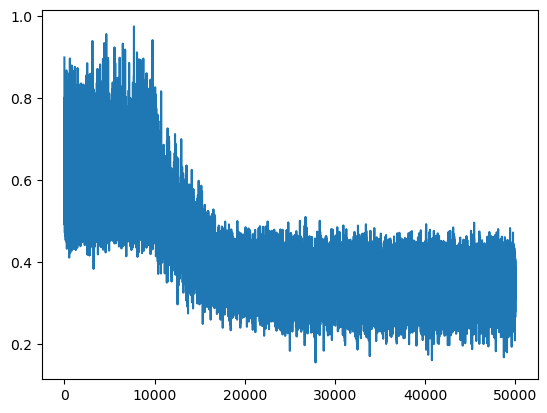

In [54]:
plt.plot(steps, lossi)
plt.show()

In [58]:
dataset = Xval
labels = Yval   
   
embedding = C[dataset] 
h = torch.tanh(embedding.view(-1,30) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, labels)  
loss

tensor(2.1557, grad_fn=<NllLossBackward0>)

In [59]:
dataset = Xtest
labels = Ytest   
   
embedding = C[dataset] 
h = torch.tanh(embedding.view(-1,30) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, labels)  
loss

tensor(2.1389, grad_fn=<NllLossBackward0>)

# Inference of the Optimized Model

In [65]:
for _ in range(20): 
    
    out = []
    context = [0] * block_size
    
    while True: 
        embedding = C[torch.tensor(context)] 
        h = torch.tanh(embedding.view(1,-1) @ W1 + b1) 
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: 
            break
    
    print(''.join(itos[i] for i in out))
 
        

luctestie.
ser.
perani.
nora.
alynn.
keiliyah.
kehashlon.
sola.
matentree.
soa.
olanarya.
eisae.
aya.
jernab.
wing.
tenia.
harley.
zae.
jarzton.
malynn.
